# GHCN Analysis

In [16]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as plt

from ghcn import load_daily

In [17]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = False

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='32GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])], n_workers=50)

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

/ext3/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33393 instead
  warnings.warn(


Client Scheduler: tcp://10.32.35.21:41065 Dashboard: http://10.32.35.21:33393/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [18]:
dask.config.set(scheduler='processes')  

In [4]:
# Get a list of all input files
# We'll sort them alphabetically to ensure reproducibility

files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_tiny/*.dly'))
#files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_small/*.dly'))
#files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_all/*.dly'))

# Load in a single file to demonstrate the parser
# Just print out the first few records to illustrate the structure
load_daily(files[0])[:3]

[{'station_id': 'ASN00002069',
  'year': 1993,
  'month': 7,
  'element': 'PRCP',
  'day': 1,
  'value': 0,
  'measurement': ' ',
  'quality': ' ',
  'source': 'a'},
 {'station_id': 'ASN00002069',
  'year': 1993,
  'month': 7,
  'element': 'PRCP',
  'day': 2,
  'value': 0,
  'measurement': ' ',
  'quality': ' ',
  'source': 'a'},
 {'station_id': 'ASN00002069',
  'year': 1993,
  'month': 7,
  'element': 'PRCP',
  'day': 3,
  'value': 0,
  'measurement': ' ',
  'quality': ' ',
  'source': 'a'}]

# Question 1:

In [5]:
#Step1: Merge multiple files into one file
file = []
for i in range(len(files)):
    temp = load_daily(files[i])
    for j in range(len(temp)):
        file.append(temp[j])

In [6]:
#Step2: Load data into dask dataframes
import pandas as pd
from dask.dataframe import from_pandas
df = pd.DataFrame(file)
ddf = from_pandas(df, npartitions=10)

In [17]:
ddf = ddf[ddf.value!=-9999]#drop rows that have missing values(value=-9999)
ddf = ddf[ddf.quality==" "]#drop rows that have bad quality

In [68]:
ddf.head()

,station_id,year,month,element,day,value,measurement,quality,source
0,AGM00060490,1957,1,TMAX,1,178,,,S
1,AGM00060490,1957,1,TMAX,2,150,,,S
2,AGM00060490,1957,1,TMAX,3,161,,,S
3,AGM00060490,1957,1,TMAX,4,172,,,S
4,AGM00060490,1957,1,TMAX,5,172,,,S


## Question 1-1: Annual PRCP

In [19]:
#Compute the annual mean PRCP across different stations
precipitation = ddf[ddf.element=="PRCP"].groupby(by=["year"]).agg({"value":"mean"}).compute()
precipitation

,value
year,
1878,19.300000
1879,26.869444
1880,15.232240
1881,14.287671
1882,13.175342
...,...
2017,31.321393
2018,32.504508
2019,29.077741


In [20]:
#Save to csv file
precipitation.to_csv("prcp-tiny.csv")

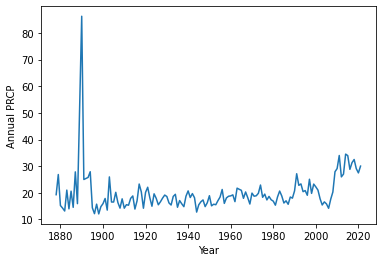

In [21]:
#Visualize the result
data = precipitation.reset_index()
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(data.year, data.value)
plt.xlabel("Year")
plt.ylabel("Annual PRCP")
plt.show()

## Question 1-2: Annual TMAX

In [22]:
#Compute the annual TMAX across different stations
temperature = ddf[ddf.element=="TMAX"].groupby(by=["year"]).agg({"value":"max"}).compute()
temperature = temperature.sort_values("year")

In [23]:
temperature 

,value
year,
1907,178
1908,328
1909,339
1910,350
1911,344
...,...
2017,428
2018,422
2019,400


In [24]:
#Save to csv file
temperature.to_csv("tmax-tiny.csv")

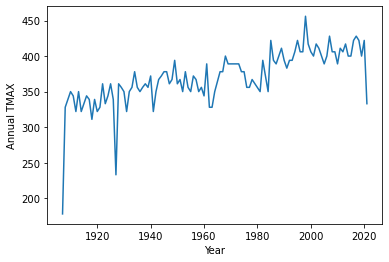

In [25]:
#Visualize the result
data2 = temperature.reset_index()
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(data2.year, data2.value)

plt.xlabel("Year")
plt.ylabel("Annual TMAX")
plt.show()

# Question 2:

## Question 2-1: prcp-small

In [26]:
files_small = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_small/*.dly'))

In [27]:
len(files_small)

1000

In [28]:
#convert .dly files to dask dataframes
import pandas as pd
from dask.dataframe import from_pandas

pd_dataframes_ = []
for i in range(len(files_small)):
    pd_dataframes_.append(pd.DataFrame(load_daily(files_small[i])))

In [29]:
ddfs = []#list of dask dataframes
for i in range(len(pd_dataframes_)):
    ddfs.append(from_pandas(pd_dataframes_[i],npartitions=1))

In [30]:
#concatenate multiple dask dataframes
ddf = dask.dataframe.multi.concat(ddfs)

In [31]:
ddf = ddf[ddf.value!=-9999]#drop rows that have missing values(value=-9999)
ddf = ddf[ddf.quality==" "]#drop rows that have bad quality

In [32]:
ddf.head()

,station_id,year,month,element,day,value,measurement,quality,source
0,AGM00060490,1957,1,TMAX,1,178,,,S
1,AGM00060490,1957,1,TMAX,2,150,,,S
2,AGM00060490,1957,1,TMAX,3,161,,,S
3,AGM00060490,1957,1,TMAX,4,172,,,S
4,AGM00060490,1957,1,TMAX,5,172,,,S


In [33]:
#Compute the annual mean PRCP across different stations
precipitation_small = ddf[ddf.element=="PRCP"].groupby(by=["year"]).agg({"value":"mean"}).compute()
precipitation_small

,value
year,
1850,11.000000
1851,22.676712
1852,25.000000
1853,19.131507
1854,17.610959
...,...
2017,27.436538
2018,29.298194
2019,28.190322


In [34]:
#save to csv file
precipitation_small.to_csv("prcp-small.csv")

## Question 2-2: tmax-small

In [35]:
#Compute the annual TMAX across different stations
temperature_small = ddf[ddf.element=="TMAX"].groupby(by=["year"]).agg({"value":"max"}).compute()
temperature_small

,value
year,
1877,311
1878,350
1879,344
1880,333
1881,361
...,...
2017,483
2018,474
2019,485


In [36]:
#save to csv file
temperature_small.to_csv("tmax-small.csv")

## Question 2-3: prcp-all

In [4]:
import pandas as pd
from dask.dataframe import from_pandas
import dask.dataframe as dd
from dask import compute
from dask import delayed
import dask.bag as db

In [5]:
files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_all/*.dly'))
load_daily(files[0])[:3]

[{'station_id': 'ACW00011604',
  'year': 1949,
  'month': 1,
  'element': 'TMAX',
  'day': 1,
  'value': 289,
  'measurement': ' ',
  'quality': ' ',
  'source': 'X'},
 {'station_id': 'ACW00011604',
  'year': 1949,
  'month': 1,
  'element': 'TMAX',
  'day': 2,
  'value': 289,
  'measurement': ' ',
  'quality': ' ',
  'source': 'X'},
 {'station_id': 'ACW00011604',
  'year': 1949,
  'month': 1,
  'element': 'TMAX',
  'day': 3,
  'value': 283,
  'measurement': ' ',
  'quality': ' ',
  'source': 'X'}]

In [6]:
b = db.from_sequence(files, npartitions = 10000).map(load_daily).flatten()

In [7]:
dk_prcp = b.filter(lambda x: x['element'] == 'PRCP' and x['quality'] == ' ' and x['value'] != -9999).to_dataframe()

In [8]:
#compute the mean prcp
mean_prcp = dk_prcp.groupby(by=["year"]).agg({"value":"mean"}).compute().sort_values("year")

In [9]:
mean_prcp

,value
year,
1781,24.558904
1782,13.712329
1783,17.832877
1784,16.576503
1785,16.169863
...,...
2017,28.086188
2018,28.818076
2019,27.960530


In [10]:
#save to csv file
mean_prcp.to_csv("prcp-all.csv")

## Question 2-4: tmax-all

In [11]:
dk_temp = b.filter(lambda x: x['element'] == 'TMAX' and x['quality'] == ' ' and x['value'] != -9999).to_dataframe()

In [12]:
max_temp = dk_temp.groupby(by=["year"]).agg({"value":"max"}).compute().sort_values("year") 

In [13]:
max_temp

,value
year,
1763,309
1764,301
1765,292
1766,301
1767,301
...,...
2017,529
2018,528
2019,532


In [14]:
#save to csv file
max_temp.to_csv("tmax-all.csv")